# Model validation

In [1]:
!python -c "import jax; print(jax.default_backend(), jax.devices())"
import os; os.environ['XLA_PYTHON_CLIENT_MEM_FRACTION']='.99' # NOTE: jax preallocates GPU (default 75%)
# from jax.config import config; config.update("jax_debug_nans", True)

import matplotlib.pyplot as plt
import numpy as np
import jax.numpy as jnp
import jax.random as jr
from jax import jit, vmap, grad, debug, lax, flatten_util, pmap
from jax.tree_util import tree_map

import numpyro
from numpyro.handlers import seed, condition, trace
from functools import partial
from getdist import plots, MCSamples

%matplotlib inline
%load_ext autoreload 
%autoreload 2

# import mlflow
# mlflow.set_tracking_uri(uri="http://127.0.0.1:8080")
# mlflow.set_experiment("Model Validation")
from montecosmo.utils import pickle_dump, pickle_load, get_vlim, theme_switch
save_dir = os.path.expanduser("~/scratch/pickles/")

gpu [cuda(id=0)]


## Render model

2024-07-07 12:36:02.579984: W external/xla/xla/service/gpu/nvptx_compiler.cc:742] The NVIDIA driver's CUDA version is 11.5 which is older than the ptxas CUDA version (11.8.89). Because the driver is older than the ptxas version, XLA is disabling parallel compilation, which may slow down compilation. You should update your NVIDIA driver or use the NVIDIA-provided CUDA forward compatibility packages.


# CONFIG
{'mesh_size': array([256, 256, 256]), 'box_size': array([640., 640., 640.]), 'a_lpt': 0.1, 'a_obs': 0.5, 'lpt_order': 2, 'galaxy_density': 0.001, 'trace_reparam': True, 'trace_meshes': True, 'prior_config': {'Omega_m': ['{\\Omega}_m', 0.3111, 0.2], 'sigma8': ['{\\sigma}_8', 0.8102, 0.2], 'b1': ['{b}_1', 1.0, 0.5], 'b2': ['{b}_2', 0.0, 2.0], 'bs2': ['{b}_{s^2}', 0.0, 2.0], 'bn2': ['{b}_{\\nabla^2}', 0.0, 2.0], 'init_mesh': ['{\\delta}_L', None, None]}, 'fourier': False, 'lik_config': {'obs_std': 1.0}}

# INFOS
cell_size:        [2.5, 2.5, 2.5] Mpc/h
delta_k:          0.00982 h/Mpc
k_nyquist:        1.25664 h/Mpc
mean_gxy_density: 0.016 gxy/cell



/feynman/work/dphp/hs276503/envs/montenvtest2/lib/python3.12/site-packages/jax/_src/numpy/array_methods.py:66: UserWarning: Explicitly requested dtype <class 'jax.numpy.int64'> requested in astype is not available, and will be truncated to dtype int32. To enable more dtypes, set the jax_enable_x64 configuration option or the JAX_ENABLE_X64 shell environment variable. See https://github.com/google/jax#current-gotchas for more.
  return lax_numpy.astype(arr, dtype)
/feynman/work/dphp/hs276503/envs/montenvtest2/lib/python3.12/site-packages/jax/_src/numpy/array_methods.py:66: UserWarning: Explicitly requested dtype <class 'jax.numpy.int64'> requested in astype is not available, and will be truncated to dtype int32. To enable more dtypes, set the jax_enable_x64 configuration option or the JAX_ENABLE_X64 shell environment variable. See https://github.com/google/jax#current-gotchas for more.
  return lax_numpy.astype(arr, dtype)
/feynman/work/dphp/hs276503/envs/montenvtest2/lib/python3.12/sit

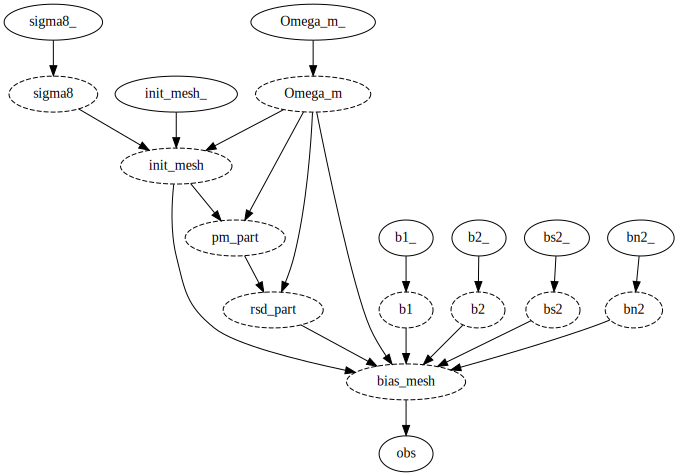

In [2]:
from montecosmo.models import pmrsd_model, prior_model, get_logp_fn, get_score_fn, get_simulator, get_pk_fn, get_param_fn, get_cosmology
from montecosmo.models import print_config, get_prior_loc, default_config as config
# Build and render model
config.update(a_lpt=0.1, a_obs=0.5, mesh_size=256*np.ones(3, dtype=int), box_size=640*np.ones(3), 
            #   trace_reparam=True, trace_meshes=True, fourier=False) # 256 requires 20Gio, 1000
              trace_reparam=True, trace_meshes=True, fourier=False) # 256 requires 20Gio, 1000
# config['prior_config']['b2'][1] = 0
# config['prior_config']['b1'][1] =8 1
model = partial(pmrsd_model, **config)
print_config(model)
numpyro.render_model(model=model, render_params=True) # filename="model_DAG.png"

## Simulate fiducial

In [3]:
# Get fiducial parameters
param_fn = get_param_fn(**config)
fiduc_model = condition(partial(model, trace_reparam=True), param_fn(inverse=True, **get_prior_loc(model)))
fiduc_simulator = get_simulator(fiduc_model)
a_lpt, a_obs = 0.1, 1.
fiduc_trace = fiduc_simulator(0, dict(a_lpt=a_obs, a_obs=a_obs, lpt_order=1, trace_meshes=1))
fiduc_trace2 = fiduc_simulator(0, dict(a_lpt=a_obs, a_obs=a_obs,lpt_order=2, trace_meshes=1))
fiduc_trace_pm = fiduc_simulator(0, dict(a_lpt=a_lpt, a_obs=a_obs, lpt_order=1, trace_meshes=3))
fiduc_cosmo = get_cosmology(**fiduc_trace)
print(f"Fiducial {fiduc_cosmo}")

/feynman/work/dphp/hs276503/envs/montenvtest2/lib/python3.12/site-packages/jax/_src/numpy/array_methods.py:66: UserWarning: Explicitly requested dtype <class 'jax.numpy.int64'> requested in astype is not available, and will be truncated to dtype int32. To enable more dtypes, set the jax_enable_x64 configuration option or the JAX_ENABLE_X64 shell environment variable. See https://github.com/google/jax#current-gotchas for more.
  return lax_numpy.astype(arr, dtype)
/feynman/work/dphp/hs276503/envs/montenvtest2/lib/python3.12/site-packages/jax/_src/numpy/array_methods.py:66: UserWarning: Explicitly requested dtype <class 'jax.numpy.int64'> requested in astype is not available, and will be truncated to dtype int32. To enable more dtypes, set the jax_enable_x64 configuration option or the JAX_ENABLE_X64 shell environment variable. See https://github.com/google/jax#current-gotchas for more.
  return lax_numpy.astype(arr, dtype)


1


/feynman/work/dphp/hs276503/envs/montenvtest2/lib/python3.12/site-packages/jax/_src/numpy/array_methods.py:66: UserWarning: Explicitly requested dtype <class 'jax.numpy.int64'> requested in astype is not available, and will be truncated to dtype int32. To enable more dtypes, set the jax_enable_x64 configuration option or the JAX_ENABLE_X64 shell environment variable. See https://github.com/google/jax#current-gotchas for more.
  return lax_numpy.astype(arr, dtype)
/feynman/work/dphp/hs276503/envs/montenvtest2/lib/python3.12/site-packages/jax/_src/numpy/array_methods.py:66: UserWarning: Explicitly requested dtype <class 'jax.numpy.int64'> requested in astype is not available, and will be truncated to dtype int32. To enable more dtypes, set the jax_enable_x64 configuration option or the JAX_ENABLE_X64 shell environment variable. See https://github.com/google/jax#current-gotchas for more.
  return lax_numpy.astype(arr, dtype)
/feynman/work/dphp/hs276503/envs/montenvtest2/lib/python3.12/sit

2


/feynman/work/dphp/hs276503/envs/montenvtest2/lib/python3.12/site-packages/jax/_src/numpy/array_methods.py:66: UserWarning: Explicitly requested dtype <class 'jax.numpy.int64'> requested in astype is not available, and will be truncated to dtype int32. To enable more dtypes, set the jax_enable_x64 configuration option or the JAX_ENABLE_X64 shell environment variable. See https://github.com/google/jax#current-gotchas for more.
  return lax_numpy.astype(arr, dtype)
/feynman/work/dphp/hs276503/envs/montenvtest2/lib/python3.12/site-packages/jax/_src/numpy/array_methods.py:66: UserWarning: Explicitly requested dtype <class 'jax.numpy.int64'> requested in astype is not available, and will be truncated to dtype int32. To enable more dtypes, set the jax_enable_x64 configuration option or the JAX_ENABLE_X64 shell environment variable. See https://github.com/google/jax#current-gotchas for more.
  return lax_numpy.astype(arr, dtype)
/feynman/work/dphp/hs276503/envs/montenvtest2/lib/python3.12/sit

1


/feynman/work/dphp/hs276503/envs/montenvtest2/lib/python3.12/site-packages/jax/_src/numpy/array_methods.py:66: UserWarning: Explicitly requested dtype <class 'jax.numpy.int64'> requested in astype is not available, and will be truncated to dtype int32. To enable more dtypes, set the jax_enable_x64 configuration option or the JAX_ENABLE_X64 shell environment variable. See https://github.com/google/jax#current-gotchas for more.
  return lax_numpy.astype(arr, dtype)


n_solvsteps: 5
Fiducial Cosmological parameters: 
    h:        0.6766 
    Omega_b:  0.049 
    Omega_c:  0.2621 
    Omega_k:  0.0 
    w0:       -1.0 
    wa:       0.0 
    n:        0.9665 
    sigma8:   0.8102


In [4]:
from numpy.testing import assert_allclose
assert_allclose(fiduc_trace['init_mesh'], fiduc_trace2['init_mesh'])
assert_allclose(fiduc_trace['init_mesh'], fiduc_trace_pm['init_mesh'])

## Power spectra

In [14]:
import numpy as np
from scipy.interpolate import interp1d
from scipy.integrate import ode
import warnings

class LPT3(object) :
    
    def __init__(self, box_length, num_mesh_1d, Omega_m, Omega_k=0) :
        '''
            Class for computing 3rd order Lagrangian perturbation theory displacement potentials and displacements up to third order.
            
            box_length: length of one side of cube
            num_mesh_1d: number of divisions along one dimension of cube
        '''
        self.box_length = box_length
        self.num_mesh_1d = num_mesh_1d
        self.Omega_m = Omega_m
        self.Omega_k = Omega_k
        self.Omega_de = 1 - self.Omega_m - self.Omega_k
        self.half_num_mesh_1d = np.uint32(np.floor(num_mesh_1d / 2))
        self.num_modes_last_d = self.half_num_mesh_1d + 1
        self.bin_volume = (self.box_length / self.num_mesh_1d) ** 3
        self.fundamental_mode = 2. * np.pi / self.box_length
        self.wave_numbers = np.fft.fftfreq(self.num_mesh_1d, d = 1. / self.fundamental_mode / self.num_mesh_1d)
        self.field_shape = [self.num_mesh_1d, self.num_mesh_1d, self.num_mesh_1d]
        self.modes_shape = [self.num_mesh_1d, self.num_mesh_1d, self.num_modes_last_d]
        self.H0 = 1. / 2.99792458e3 # in units of h / Mpc
        self._initializeGrowthTables()
        

    def _getESquared(self, a) :
        '''Returns Hubble rate squared in units of H_0^2 at scale factor a.'''
        return self.Omega_m * a ** -3 + self.Omega_k * a ** -2 + self.Omega_de
        
    def _getE(self, a) :
        '''Returns Hubble rate squared in units of H_0^2 at scale factor a.'''
        return np.sqrt(self._getESquared(a))
    
    def _getHSquared(self, a) :
        '''Returns Hubble rate squared in units of (h / Mpc) ** 2 at scale factor a.'''
        return self.H0 ** 2 * self._getESquared(a)
        
    def _getH(self, a) :
        '''Returns Hubble rate in units of h / Mpc at scale factor a.'''
        return self.H0 * self._getE(a)
    
    def _getDiffLogH(self, a) :
        '''Returns d log Hubble / d log a.'''
        return -0.5 * (3 * self.Omega_m * a ** -3 + 2 * self.Omega_k * a ** -2) / self._getESquared(a)
    
    def _getBeta(self, a) :
        '''Returns 1.5 * Omega_m(a) at scale factor a.'''
        return 1.5 * self.Omega_m * a ** -3 / self._getESquared(a)
    
    def _fft(self, field) :
        '''Returns normalized forward Fourier transform of field so the modes has units [field] * [volume].'''
        return self.bin_volume * np.fft.rfftn(field)
    
    def _ifft(self, field) :
        '''Returns normalized backward Fourier transform of field (modes) so the position space field has units [field (modes)] / [volume].'''
        return np.fft.irfftn(field) / self.bin_volume
    
    def _getSafeReciprocal3D(self, field) :
        '''Returns 1 / field where field is in Fourier space except for the zero amplitude modes which remain zero.'''
        field[0,0,0] = 1.
        field = 1. / field
        field[0,0,0] = 0.
        return field
    
    def _getWaveVectorNorms(self) :
        '''Returns 3D array of wave vector norms.'''
        return (self.wave_numbers ** 2 + self.wave_numbers[:, None] ** 2 + self.wave_numbers[:, None, None] ** 2)[:, :, :self.num_modes_last_d]
        
    def getGrad3D(self, field, dir) :
        '''Returns gradient of field (modes) along direction dir (0, 1, or 2).'''
        if dir == 0 :
            return (field.T * 1j * self.wave_numbers).T
        elif dir == 1 :
            return (field.T * 1j * self.wave_numbers[:, None]).T
        elif dir == 2 :
            return field * 1j * (self.wave_numbers[:, None, None])[:, :, :self.num_modes_last_d]
        # else :
        #     raise ValueError('3D Index out of bounds %d' % (ind))
        return

    def getInverseLaplacian3D(self, field) :
        '''Returns inverse Laplacian of field (modes).'''
        return -field * self._getSafeReciprocal3D(self._getWaveVectorNorms())

    def getLaplacian3D(self, field) :
        '''Returns Laplacian of field (modes)'''
        return -field * self._getWaveVectorNorms()

    def getHessian3D(self, field, dirs) :
        '''Returns Hessian component of field (modes) along directions dirs = [dir1, dir2].'''
        if np.shape(dirs) != (2,) :
            raise ValueError('Hessian inds must have shape (2,).')
        return self.getGrad3D(self.getGrad3D(field, dirs[0]), dirs[1])

    def getHessian3DIFFT(self, field, dirs) :
        '''Returns backward Fourier transform of Hessian component of field (modes) along directions dirs = [dir1, dir2].'''
        return self._ifft(self.getHessian3D(field, dirs))
    
    def convolveHessian3D(self, fields, dirs) :
        '''
            Returns to convolution of the Hessian components dirs[i] of every field[i] in fields (modes)
            by multiplying their backward Fourier transforms.
        '''
        if len(fields) != len(dirs) :
            raise ValueError('dirs must be a list with the same length as fields.')
        output = np.ones(self.field_shape)
        for i, phi in enumerate(fields) :
            output *= self.getHessian3DIFFT(phi, dirs[i])
        return output
        
    def convolveHessian3DDifference(self, fields, dirs) :
        '''
            Returns to convolution of the Hessian components dirs[i] of every field[i] in fields (modes)
            by multiplying their backward Fourier transforms, expect for the final two fields whose difference
            field[-2] - field[-1] is convolved instead.
        '''
        if len(fields) != len(dirs) :
            raise ValueError('dirs must be a list with the same length as fields')
        output = np.ones(self.field_shape)
        for i, phi in enumerate(fields[:len(fields) - 2]) :
            output *= self.getHessian3DIFFT(phi, dirs[i])
        output *= self._ifft(self.getHessian3D(fields[-2], dirs[-2]) - self.getHessian3D(fields[-1], dirs[-1]))
        return output
    
    def convolveHessian3DSum(self, fields, dirs) :
        '''
            Returns to convolution of the Hessian components dirs[i] of every field[i] in fields (modes)
            by multiplying their backward Fourier transforms, expect for the final two fields whose sum
            field[-2] + field[-1] is convolved instead.
        '''
        if len(fields) != len(dirs) :
            raise ValueError('dirs must be a list with the same length as fields.')
        output = np.ones(self.field_shape)
        for i, phi in enumerate(fields[:len(fields) - 2]) :
            output *= self.getHessian3DIFFT(phi, dirs[i])
        output *= self._ifft(self.getHessian3D(fields[-2], dirs[-2]) + self.getHessian3D(fields[-1], dirs[-1]))
        return output
    
    def getLinearDelta(self, k, p, sphere_mode = True) :
        '''
            Returns a random Gaussian realization of the linear density contrast in Fourier space,
            sampled from the power spectrum interpolation table (k, p).

            k: array of wave numbers for interpolate, in units of box_length ** -1
            p: array of power spectrum values at k, in units of k ** -3
            sphere_mode: if True sets all modes with k > nyquist to zero
        '''
        sigma = np.sqrt(p * self.box_length ** 3)
        k_grid = np.sqrt(self._getWaveVectorNorms())
        noise = np.fft.rfftn(np.random.randn(self.num_mesh_1d, self.num_mesh_1d, self.num_mesh_1d)) / self.num_mesh_1d ** 1.5
        if sphere_mode :
            nyqiust_mode = self.fundamental_mode * self.half_num_mesh_1d
            noise[k_grid >= nyqiust_mode] = 0.
            k_grid[k_grid >= nyqiust_mode] = 0.
        noise[k_grid > 0.] *= np.exp(interp1d(np.log(k), np.log(sigma))(np.log(k_grid[k_grid > 0.])))
        return noise
    
    def _initializeGrowthTables(self, zi = 1.e6, zf = -0.01, num_z = 1024, nstep = 100, rtol = 1.e-3, atol = 1.e-10) :
        '''
            Numerically intergrates the growth equations for LPT growth factors up to 3rd order, initializes the internal interpolation tables
            for all growth factors and growth rates.
        '''
        #
        # Log scale factors for interpolation tables
        #
        self.log_a = np.linspace(-np.log(1. + zi), -np.log(1. + zf), 1024)
        #
        # Initial conditions assuming matter domination (radiation is ignored)
        #
        a = np.exp(self.log_a[0])
        D1 = a - 2 / 77 * (22 * a ** 2 * self.Omega_k + 7 * a ** 4 * self.Omega_de) / self.Omega_m
        dD1 = a - 8 / 77 * (11 * a ** 2 * self.Omega_k + 7 * a ** 4 * self.Omega_de) / self.Omega_m
        D2 = 3 / 7 * a ** 2 - 1 / 3003 * (1430 * a ** 3 * self.Omega_k + 459 * a ** 5 * self.Omega_de) / self.Omega_m
        dD2 = 6 / 7 * a ** 2 - 1 / 3003 * (4290 * a ** 3 * self.Omega_k + 2295 * a ** 5 * self.Omega_de) / self.Omega_m
        D3a = 1 / 14 * a ** 3 - 2 / 525525 * (30875 * a ** 4 * self.Omega_k + 9933 * a ** 6 * self.Omega_de) / self.Omega_m
        dD3a = 3 / 14 * a ** 3 - 4 / 525525 * (61750 * a ** 4 * self.Omega_k + 29799 * a ** 6 * self.Omega_de) / self.Omega_m
        D3b = 1 / 6 * a ** 3 - 1 / 5775 * (1600 * a ** 4 * self.Omega_k + 511 * a ** 6 * self.Omega_de) / self.Omega_m
        dD3b = 1 / 2 * a ** 3 - 1 / 5775 * (6400 * a ** 4 * self.Omega_k + 3066 * a ** 6 * self.Omega_de) / self.Omega_m
        D3c = 1 / 7 * a ** 3 - 1 / 3003 * (715 * a ** 4 * self.Omega_k + 228 * a ** 6 * self.Omega_de) / self.Omega_m
        dD3c = 3 / 7 * a ** 3 - 4 / 3003 * (715 * a ** 4 * self.Omega_k + 342 * a ** 6 * self.Omega_de) / self.Omega_m
        
        # initials = [D1, dD2, D2, dD2, D3a, dD3a, D3b, dD3b, D3c, dD3c]
        initials = [D1, dD1, D2, dD2, D3a, dD3a, D3b, dD3b, D3c, dD3c]
        #
        # ODEs for LPT growth factors up to order 3 assuming flat LCDM
        #
        def _get_deqs(t_log_a, t_state) :
            # print(t_log_a, "\ntstate", t_state)
            # D1, dD1, D2, dD2, D3a, dD3a, D3b, dD3b = t_state
            D1, dD1, D2, dD2, D3a, dD3a, D3b, dD3b, D3c, dD3c = t_state
            t_a = np.exp(t_log_a)
            beta = self._getBeta(t_a)
            alpha = 2. + self._getDiffLogH(t_a)
            deqs = np.zeros(10)
            deqs[0] = dD1
            deqs[1] = alpha * dD1 + beta * D1
            deqs[2] = dD2
            deqs[3] = alpha * dD2 + beta * (D2 + D1 ** 2)
            deqs[4] = dD3a
            deqs[5] = alpha * dD3a + beta * (D3a + D1 ** 3)
            deqs[6] = dD3b
            deqs[7] = alpha * dD3b + beta * (D3b + D1 * D2)
            deqs[8] = dD3c
            deqs[9] = alpha * dD3c + beta * D1 ** 3
            return deqs
        #
        # Initialize integrator
        #
        growth_odes = ode(_get_deqs)
        growth_odes.set_integrator('lsoda', nsteps = nstep, rtol = rtol, atol = atol)
        self.growth_factors = [initials[::2]]
        self.growth_rates = [initials[1::2]]
        growth_odes.set_initial_value(initials, self.log_a[0])
        #
        # Loop through log(a) array to build interpolation tables
        #
        for t_log_a in self.log_a[1:] :
            growth_odes.integrate(t_log_a)
            if not growth_odes.successful() :
                if not self.quiet :
                    warnings.warn("LPT3.initializeGrowthTables failed to integrate at log(a) = %.6e." % (growth_odes.t))
                break
            self.growth_factors.append(growth_odes.y[::2])
            self.growth_rates.append(self._getH(np.exp(t_log_a)) * growth_odes.y[1::2])
        #
        # Define interal interpolators
        #
        self.growth_factors = np.array(self.growth_factors).T
        self.growth_rates = np.array(self.growth_rates).T
        self._getD1 = interp1d(self.log_a, self.growth_factors[0])
        self._getD2 = interp1d(self.log_a, self.growth_factors[1])
        self._getD3a = interp1d(self.log_a, self.growth_factors[2])
        self._getD3b = interp1d(self.log_a, self.growth_factors[3])
        self._getD3c = interp1d(self.log_a, self.growth_factors[4])
        self._getdD1 = interp1d(self.log_a, self.growth_rates[0])
        self._getdD2 = interp1d(self.log_a, self.growth_rates[1])
        self._getdD3a = interp1d(self.log_a, self.growth_rates[2])
        self._getdD3b = interp1d(self.log_a, self.growth_rates[3])
        self._getdD3c = interp1d(self.log_a, self.growth_rates[4])         

        return
    
    def getD1(self, z) :
        '''Returns first order growth factor interpolated at redshift z.'''
        return self._getD1(-np.log(1. + z))

    def getD2(self, z) :
        '''Returns second order growth factor interpolated at redshift z.'''
        return self._getD2(-np.log(1. + z))

    def getD3a(self, z) :
        '''Returns third order growth factor sourced by D1 ** 3 interpolated at redshift z.'''
        return self._getD3a(-np.log(1. + z))

    def getD3b(self, z) :
        '''Returns third order growth factor sourced by D1 * D2 interpolated at redshift z.'''
        return self._getD3b(-np.log(1. + z))

    def getD3c(self, z) :
        '''Returns transverse third order growth factor sourced by D1 ** 3 interpolated at redshift z.'''
        return self._getD3c(-np.log(1. + z))
    
    def getdD1(self, z) :
        '''Returns first order growth rate interpolated at redshift z.'''
        return self._getdD1(-np.log(1. + z))

    def getdD2(self, z) :
        '''Returns second order growth rate interpolated at redshift z.'''
        return self._getdD2(-np.log(1. + z))

    def getdD3a(self, z) :
        '''Returns third order growth rate sourced by D1 ** 3 interpolated at redshift z.'''
        return self._getdD3a(-np.log(1. + z))

    def getdD3b(self, z) :
        '''Returns third order growth rate sourced by D1 * D2 interpolated at redshift z.'''
        return self._getdD3b(-np.log(1. + z)) 

    def getdD3c(self, z) :
        '''Returns transverse third order growth rate sourced by D1 ** 3 interpolated at redshift z.'''
        return self._getdD3c(-np.log(1. + z)) 
    
    def getDisplacements(self, delta, z, t_order = 3, z_delta = None):
        '''
            Computes phi and A, the 3rd order LPT displacement scalar and vector potentials respectively at z.
            
            Returns dis, vel, the t_order displacement and velocit fields.
            
            delta: 3D Fourier modes of the linear density contrast field, if not computed at redshift z then z_delta must be given
            z: reshift of desired LPT displacements, if z_delta is None this must also be the redshift of the linear field delta
            t_order: order of Lagrangian perturbations theory (max is 3)
            z_delta: redshift of delta if different from z
        '''
        #
        # 1LPT
        #
        if z_delta is None :
            phi_1 = self.getInverseLaplacian3D(delta) / self.getD1(z)
        else :
            phi_1 = self.getInverseLaplacian3D(delta) / z_delta
        phi_dis = self.getD1(z) * phi_1
        phi_vel = self.getdD1(z) * phi_1
        if t_order > 1 :
            #
            # 2LPT
            #
            phi_2 = self.convolveHessian3DSum([phi_1, phi_1, phi_1], [[0, 0], [1, 1], [2, 2]])
            phi_2 += self.convolveHessian3D([phi_1, phi_1], [[1, 1], [2, 2]])
            for i in range(3) :
                j = (i + 1) % 3
                phi_2 -= self.convolveHessian3D([phi_1, phi_1], [[i, j], [i, j]])
            phi_2 = self.getInverseLaplacian3D(self._fft(phi_2))
            phi_dis += self.getD2(z) * phi_2
            phi_vel += self.getdD2(z) * phi_2
            if t_order > 2 :
                #
                # 3LPT Scalar
                #
                phi_3 = np.zeros(self.field_shape)
                for i in range(3) :
                    j = (i + 1) % 3
                    k = (i + 2) % 3
                    phi_3 += self.convolveHessian3DSum([phi_1, phi_2, phi_2], [[i, i], [j, j], [k, k]])
                    phi_3 -= 2. * self.convolveHessian3D([phi_1, phi_2], [[i, j], [i, j]])
                phi_dis += self.getD3b(z) * self.getInverseLaplacian3D(self._fft(phi_3))
                phi_vel += self.getdD3b(z) * self.getInverseLaplacian3D(self._fft(phi_3))
                phi_3 += self.convolveHessian3D([phi_1, phi_1, phi_1], [[0, 0], [1, 1], [2, 2]])
                phi_3 += 2. * self.convolveHessian3D([phi_1, phi_1, phi_1], [[0, 1], [1, 2], [2, 0]])
                for i in range(3) :
                    j = (i + 1) % 3
                    k = (i + 2) % 3 
                    phi_3 -= self.convolveHessian3D([phi_1, phi_1, phi_1], [[i, i], [j, k], [j, k]])
                phi_3 = self.getInverseLaplacian3D(self._fft(phi_3))
                phi_dis += self.getD3a(z) * phi_3
                phi_vel += self.getdD3a(z) * phi_3
                del(phi_3)
                #
                #3 LPT Vector
                #
                A = np.zeros([3] + self.field_shape)
                for i in range(3) :
                    j = (i + 1) % 3
                    k = (i + 2) % 3
                    A[i] += self.convolveHessian3D([phi_2, phi_1], [[i, j], [i, k]])
                    A[i] -= self.convolveHessian3D([phi_1, phi_2], [[i, j], [i, k]])
                    A[i] += self.convolveHessian3DDifference([phi_1, phi_2, phi_2], [[j, k], [j, j], [k, k]])
                    A[i] -= self.convolveHessian3DDifference([phi_2, phi_1, phi_1], [[j, k], [j, j], [k, k]])
                del(phi_1)
                del(phi_2)
                A = np.array([self.getInverseLaplacian3D(self._fft(t_A)) for t_A in A])
        #
        # Convert potentials to displacements, Note only the vector potential hasn't been scaled by its growth factor/rate
        #
        dis = []
        vel = []
        for i in range(3) :
            t_dis = -self._ifft(self.getGrad3D(phi_dis, i))
            t_vel = -self._ifft(self.getGrad3D(phi_vel, i))
            if t_order > 2 :
                j = (i + 1) % 3
                k = (i + 2) % 3
                curl = self._ifft(self.getGrad3D(A[k], j) - self.getGrad3D(A[j], k))
                t_dis += self.getD3c(z) * curl
                t_vel += self.getdD3c(z) * curl
            dis.append(t_dis)
            vel.append(t_vel)
        return np.array(dis), np.array(vel)


In [15]:
lpt3 = LPT3(config['box_size'][0], config['mesh_size'][0], 0.3111)
# lpt3.getdD2(0), growth_rate_second(cosmo, a)
pmwd_mesh = lpt3.getDisplacements(jnp.fft.rfftn(fiduc_trace['init_mesh']), z=1/a_obs-1, t_order=1)

In [14]:
from pmwd import (
    Configuration,
    Cosmology, SimpleLCDM,
    boltzmann, linear_power, growth,
    white_noise, linear_modes,
    lpt,
    nbody,
    scatter,
)
ptcl_spacing = 2.5 # Mpc/h
ptcl_grid_shape = (256,)*3
conf = Configuration(ptcl_spacing, ptcl_grid_shape, mesh_shape=1)
print(conf)
cosmo = Cosmology.from_sigma8(conf, sigma8=0.8102, n_s=0.9665, Omega_m=0.3111, Omega_b=0.049, h=0.6766)
print(cosmo), print(fiduc_cosmo);
cosmo = boltzmann(cosmo, conf)
pos_wd = lpt(jnp.fft.rfftn(fiduc_trace['init_mesh']), cosmo, conf)[0].pos().astype(jnp.float32)

Configuration(ptcl_spacing=2.5,
              ptcl_grid_shape=(256, 256, 256),
              mesh_shape=(256, 256, 256),
              cosmo_dtype=dtype('float64'),
              pmid_dtype=dtype('int16'),
              float_dtype=dtype('float32'),
              k_pivot_Mpc=0.05,
              T_cmb=2.7255,
              M=1.98847e+40,
              L=3.0856775815e+22,
              T=3.0856775815e+17,
              transfer_fit=True,
              transfer_fit_nowiggle=False,
              transfer_lgk_min=-4,
              transfer_lgk_max=3,
              transfer_lgk_maxstep=0.0078125,
              growth_rtol=1.4901161193847656e-08,
              growth_atol=1.4901161193847656e-08,
              growth_inistep=(1, None),
              lpt_order=2,
              a_start=0.015625,
              a_stop=1,
              a_lpt_maxstep=0.0078125,
              a_nbody_maxstep=0.015625,
              symp_splits=((0, 0.5), (1, 0.5)),
              chunk_size=16777216)
Cosmology(A_s_1e9

In [5]:
from jaxpm.painting import cic_paint, cic_read, compensate_cic
from montecosmo.bricks import linear_pk_interp

# Get and vectorize relevant functionals
multipoles = [0,2,4]
pk_fn = get_pk_fn(multipoles=multipoles, **config)

# Get meshes from model trace particles. Must compensate for CIC painting convolution
zeros_mesh = jnp.zeros(config['mesh_size'])
pm_mesh = vmap(cic_paint, in_axes=(None,0))(zeros_mesh, fiduc_trace['pm_part'][:,0])
pm_mesh2 = vmap(cic_paint, in_axes=(None,0))(zeros_mesh, fiduc_trace2['pm_part'][:,0])
pm_mesh_pm = vmap(cic_paint, in_axes=(None,0))(zeros_mesh, fiduc_trace_pm['pm_part'][:,0])

# Compute power spectra
pk_init = pk_fn(fiduc_trace['init_mesh'])
pk_pm = vmap(pk_fn)(vmap(compensate_cic)(pm_mesh))
pk_pm2 = vmap(pk_fn)(vmap(compensate_cic)(pm_mesh2))
pk_pm_pm = vmap(pk_fn)(vmap(compensate_cic)(pm_mesh_pm))
# pk_obs = pk_fn(compensate_cic(fiduc_trace['obs_mesh']))
pk_lin_init = jnp.array([pk_init[0], linear_pk_interp(fiduc_cosmo)(pk_init[0])])
pk_lin_obs = jnp.array([pk_init[0], linear_pk_interp(fiduc_cosmo, a=a_obs)(pk_init[0])])
del fiduc_trace2
del fiduc_trace_pm

/feynman/work/dphp/hs276503/envs/montenvtest2/lib/python3.12/site-packages/jax/_src/numpy/array_methods.py:66: UserWarning: Explicitly requested dtype <class 'jax.numpy.int64'> requested in astype is not available, and will be truncated to dtype int32. To enable more dtypes, set the jax_enable_x64 configuration option or the JAX_ENABLE_X64 shell environment variable. See https://github.com/google/jax#current-gotchas for more.
  return lax_numpy.astype(arr, dtype)
/feynman/work/dphp/hs276503/envs/montenvtest2/lib/python3.12/site-packages/jax/_src/numpy/array_methods.py:66: UserWarning: Explicitly requested dtype <class 'jax.numpy.int64'> requested in astype is not available, and will be truncated to dtype int32. To enable more dtypes, set the jax_enable_x64 configuration option or the JAX_ENABLE_X64 shell environment variable. See https://github.com/google/jax#current-gotchas for more.
  return lax_numpy.astype(arr, dtype)
/feynman/work/dphp/hs276503/envs/montenvtest2/lib/python3.12/sit

In [19]:
# pos = jnp.moveaxis(pmwd_mesh[0], 0, -1).reshape(3,-1).T
# pk_pmwd = pk_fn(compensate_cic(cic_paint(zeros_mesh, pos)))
zeros_mesh = jnp.zeros(config['mesh_size'], dtype=jnp.float64)
pk_pmwd = pk_fn(compensate_cic(cic_paint(zeros_mesh, pos_wd)))

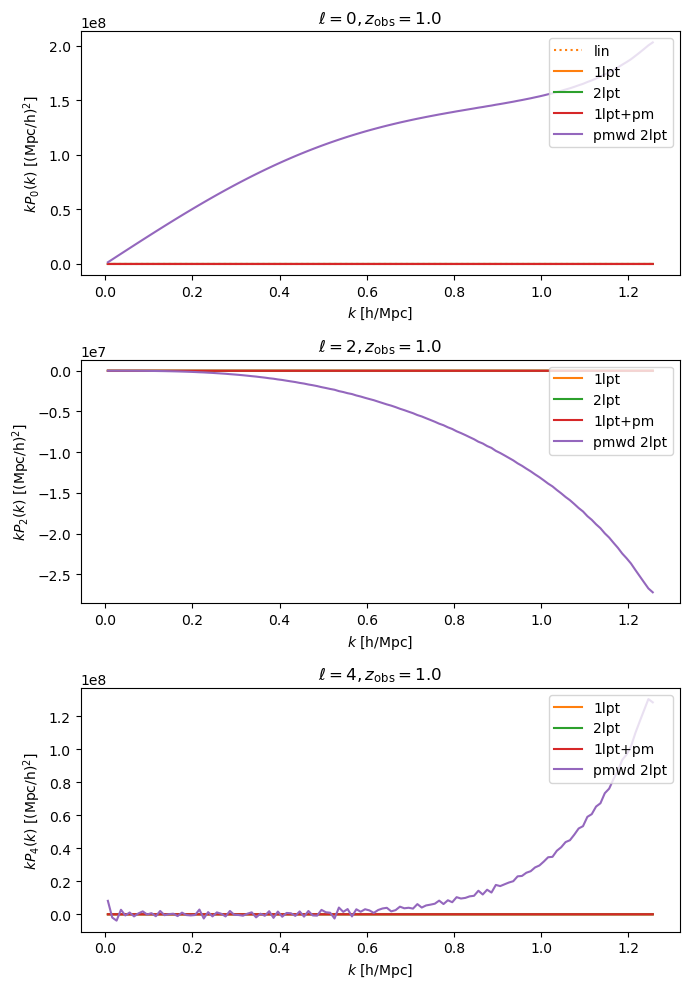

In [9]:
plt.figure(figsize=(7,10))
for i_pole, multipole in enumerate(multipoles):
    plt.subplot(len(multipoles), 1, i_pole+1)
    plot_fn = lambda pk, *args, **kwargs: plt.plot(pk[0], pk[0]*pk[i_pole+1], *args, **kwargs)
    # plot_fn = lambda pk, *args, **kwargs: plt.semilogy(pk[0], pk[i_pole+1], *args, **kwargs)

    if multipole==0:
        plot_fn(pk_lin_obs, 'C1:', label=f"lin")
    # if multipole==0:
    #     plot_fn(pk_lin_init, 'C0:', label=f"lin (z={1/1-1:.1f})")

    plot_fn(pk_pm[-1], 'C1', label=f"1lpt")    
    for pk in pk_pm[:-1]:
        plot_fn(pk, 'C1', alpha=0.2)

    plot_fn(pk_pm2[-1], 'C2', label=f"2lpt")    
    for pk in pk_pm2[:-1]:
        plot_fn(pk, 'C2', alpha=0.2)

    plot_fn(pk_pm_pm[-1], 'C3', label=f"1lpt+pm")    
    for pk in pk_pm_pm[:-1]:
        plot_fn(pk, 'C3', alpha=0.2)

    plot_fn(pk_pmwd, 'C4', label=f"pmwd 2lpt")
    # plot_fn(pk_init, 'C0', label=f"init (z={1/1-1:.1f})")

    if multipole==0: plt.legend(loc='upper right')
    else: plt.legend(loc='upper right')
    plt.xlabel("$k$ [h/Mpc]"), plt.ylabel(f"$k P_{multipole}(k)$ [(Mpc/h)$^2$]")
    plt.title("$\\ell="+f"{multipole}, "+"z_{\\text{obs}}="+f"{1/config['a_obs']-1:.1f}$")
plt.tight_layout()
# mlflow.log_figure(plt.gcf(), f"pkl_rsd{rsd:b}_smooth{smooth:b}.svg")
# plt.savefig('pkl_history.svg', dpi=200, bbox_inches='tight')
plt.show();

In [5]:
from jaxpm.growth import growth_factor, growth_rate, dGfa, growth_factor_second, growth_rate_second, dGf2a
from montecosmo.bricks import Planck18
cosmo = Planck18()
Om = cosmo.Omega_m
a = jnp.atleast_1d(1.)
(Om*a**-3)**(5/9), growth_rate(cosmo, a), 2*(Om*a**-3)**(6/11), growth_rate_second(cosmo, a)
# a, growth_factor(cosmo, a), a**2, growth_factor_second(cosmo, a)

/feynman/work/dphp/hs276503/envs/montenvtest2/lib/python3.12/site-packages/jax/_src/numpy/array_methods.py:66: UserWarning: Explicitly requested dtype <class 'jax.numpy.int64'> requested in astype is not available, and will be truncated to dtype int32. To enable more dtypes, set the jax_enable_x64 configuration option or the JAX_ENABLE_X64 shell environment variable. See https://github.com/google/jax#current-gotchas for more.
  return lax_numpy.astype(arr, dtype)


(Array([0.52142227], dtype=float32, weak_type=True),
 Array([0.52208537], dtype=float32),
 Array([1.0552651], dtype=float32, weak_type=True),
 Array([1.0588487], dtype=float32))